In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# This tells us how many dates are recorded.
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [10]:
# Find the most recent date in the data set.
recentdate = session.query(Measurement.date).order_by(Measurement.date).first()
print(f"Most Recent Date: {recentdate[0]}")

Most Recent Date: 2010-01-01


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostrecent = dt.datetime.strptime(recentdate[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydate = dt.date(mostrecent.year -1, mostrecent.month, mostrecent.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(queryresult, columns=['Date', 'Precipitation'])

# clean up non value entries
precipitation = precipitation.dropna(how='any') 

# Sort the dataframe by date
precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()



,Precipitation
Date,
2010-01-01,0.08
2010-01-01,0.15
2010-01-01,0.28
2010-01-01,0.05
2010-01-01,0.14


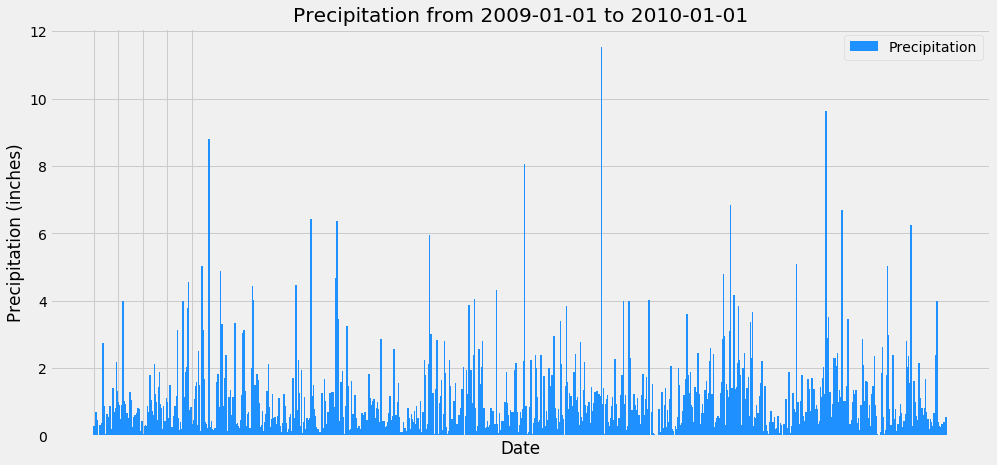

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

x_axis = precipitation.index.tolist()
y_axis = precipitation['Precipitation'].tolist()

plt.figure(figsize=(15,7))
plt.bar(x_axis,y_axis,width = 5 ,color='dodgerblue', alpha=1, align="center",label='Precipitation')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,         
    labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {recentdate[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
mostactive = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
mostactive

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactive = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactive

(54.0, 85.0, 71.66378066378067)

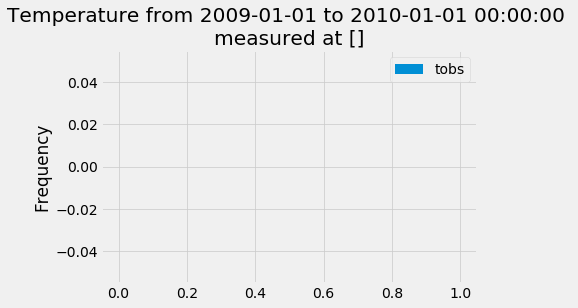

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == mostactive[0],"Name"].tolist()

# n, bins, patches = plt.hist(temperatures, bins=12,alpha=0.7, rwidth=1.0,label='tobs')
plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {querydate} to {mostrecent} \nmeasured at {stationname}")
plt.legend()

# Close session

In [ ]:
# Close Session
session.close()